In [262]:
import gurobipy as gp
from gurobipy import GRB
import random
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
import warnings
from tqdm import tqdm_notebook as tqdm
import requests
import json
import API
import matplotlib.pyplot as plt
import GoogleDistanceMatrix
import GoogleVRP
import routing
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
warnings.filterwarnings('ignore')

# Current shared

In [168]:
order = pd.read_excel('../1. Sales Data/DMS order_2-6Nov2020 (Only store with DMS available)+Transportation.xlsx')
order = order.loc[order['Instant Order']==True]
store = pd.read_csv('Data/StoreLocation.csv')

In [169]:
order['orderTime'] = pd.to_datetime(order['下單時間'])
order['arrivalTime'] = pd.to_datetime(order['訂單送達時間'])
order['departureTime'] = pd.to_datetime(order['取餐出發時間'])

order['waitingTime'] = order['arrivalTime'] - order['orderTime']
order['tripDurationReal'] = pd.to_datetime(order['訂單送達時間']) - pd.to_datetime(order['departureTime'])
order['tripDurationReal'] = order['tripDurationReal'].dt.seconds

In [170]:
order.shape

(505, 20)

In [171]:
order['waitingTime'].describe()

count                       505
mean     0 days 00:36:08.730693
std      0 days 00:12:27.626481
min             0 days 00:16:02
25%             0 days 00:27:42
50%             0 days 00:33:46
75%             0 days 00:41:05
max             0 days 01:33:23
Name: waitingTime, dtype: object

In [172]:
order = order.sort_values(by=['取餐出發時間','Rider'])
order['last取餐出發時間'] = order['取餐出發時間'].shift(1)
order['lastRider'] = order['Rider'].shift(1)
order['pre取餐出發時間'] = order['取餐出發時間'].shift(-1)
order['preRider'] = order['Rider'].shift(-1)

In [173]:

shared = order.loc[((order['last取餐出發時間']==order['取餐出發時間'])&(order['lastRider']==order['Rider']))|
                   ((order['pre取餐出發時間']==order['取餐出發時間'])&(order['preRider']==order['Rider']))]
single = order.loc[((order['last取餐出發時間']!=order['取餐出發時間'])|(order['lastRider']!=order['Rider']))|
                   ((order['pre取餐出發時間']!=order['取餐出發時間'])|(order['preRider']!=order['Rider']))]

In [174]:
order.shape

(505, 24)

In [175]:
shared.shape

(140, 24)

In [176]:
order.loc[order['Rider']=='3rdParty'].shape

(13, 24)

In [177]:
order['shared'] = 0
order.loc[((order['last取餐出發時間']==order['取餐出發時間'])&(order['lastRider']==order['Rider']))|
                   ((order['pre取餐出發時間']==order['取餐出發時間'])&(order['preRider']==order['Rider'])),'shared'] = 1

In [178]:
shared['waitingTime'].describe()

count                       140
mean     0 days 00:42:49.835714
std      0 days 00:14:38.349003
min             0 days 00:20:14
25%      0 days 00:33:26.750000
50%      0 days 00:39:02.500000
75%      0 days 00:47:33.500000
max             0 days 01:33:23
Name: waitingTime, dtype: object

In [179]:
single['waitingTime'].describe()

count                       501
mean     0 days 00:36:00.670658
std      0 days 00:12:17.632204
min             0 days 00:16:02
25%             0 days 00:27:42
50%             0 days 00:33:43
75%             0 days 00:40:49
max             0 days 01:33:23
Name: waitingTime, dtype: object

## data preprocessing

In [180]:
def get_lat_lon(x):
    location = x['配送地址']
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address=香港'+location+'&key='+API.key
    data = requests.get(url)
    text = json.loads(data.text)
    if text['results'] == []:
        return('missing')
    lat = str(text['results'][0]['geometry']['location']['lat'])
    lng = str(text['results'][0]['geometry']['location']['lng'])
    return(lat+','+lng)

In [182]:
order['DeliveryLatLon'] = order.apply(get_lat_lon,axis=1)

In [183]:
def tripDurationFromGoogle(x):
    # distance matrix API
    StoreLatLon,DeliveryLatLon = x['StoreLatLon'],x['DeliveryLatLon']
    url = 'https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&origins='+StoreLatLon+\
    '&destinations='+DeliveryLatLon+'&key='+API.key
    data = requests.get(url)
    text = json.loads(data.text)
    if text['rows'] != []:
        if 'duration' in text['rows'][0]['elements'][0]:
            
            duration = text['rows'][0]['elements'][0]['duration']['value']
            return duration
    else:
        return 'missing'

In [184]:
order = order[['日期', '門店名稱', '配送地址', '下單時間', '指派成功時間', '騎手接單時間', '到店取餐時間', '取餐出發時間',
       '訂單送達時間', '預送達時間', 'Banner', 'Instant Order', '收貨地址坐標', 'Rider',
       'Transportation', 'orderTime', 'arrivalTime', 'waitingTime',
       'last取餐出發時間', 'lastRider', 'departureTime', 'tripDurationReal',
       'DeliveryLatLon','shared']]

In [185]:
order = order.merge(store, how='left',left_on='門店名稱', right_on='storeCode')
order['StoreLatLon'] = order['lat'].astype(str)+','+order['lon'].astype(str)

In [186]:
order['tripDurationFromGoogle'] = order.apply(lambda x:tripDurationFromGoogle(x),axis=1)

In [187]:
order['tripDurationFromGoogle'].fillna('missing',inplace=True)
order = order.loc[order['tripDurationFromGoogle']!='missing']
order['tripDurationFromGoogle'] = order['tripDurationFromGoogle'].astype(int)

In [188]:
order.loc[order['shared']==0]['tripDurationFromGoogle'].mean()/60

7.861309523809524

In [189]:
order.loc[order['shared']==0]['tripDurationReal'].mean()/60

15.14386446886447

In [190]:
timeParameter = (order['tripDurationReal']/60).mean() / (order['tripDurationFromGoogle']/60).mean()
timeParameter

2.087588159544255

In [191]:
order['foodPreparationTime'] = pd.to_datetime(order['取餐出發時間']) - pd.to_datetime(order['下單時間'])

In [192]:
order.loc[order['shared']==0]['foodPreparationTime'].mean()

Timedelta('0 days 00:18:27.579670')

In [193]:
order.loc[order['shared']==1]['foodPreparationTime'].mean()

Timedelta('0 days 00:23:49.812949')

In [194]:
order.to_csv('Data/ProcessedNov.csv',index=False)

## modelling

In [200]:
order = pd.read_csv('Data/ProcessedNov.csv')

In [201]:
order.shape

(503, 30)

In [202]:
order['門店名稱'].unique()

array(['PH64', 'PH57', 'PHD629', 'PHD606'], dtype=object)

In [203]:
order = order.loc[order['門店名稱'].isin(['PH57','PHD629'])]
order.shape

(310, 30)

In [204]:
order.loc[order['Rider']=='3rdParty'].shape

(6, 30)

In [205]:
order['foodPreparationTime'] = pd.to_datetime(order['取餐出發時間']) - pd.to_datetime(order['下單時間'])

In [206]:
order.loc[order['shared']==0]['foodPreparationTime'].mean()

Timedelta('0 days 00:19:05.130653')

In [207]:
order.loc[order['shared']==1]['foodPreparationTime'].mean()

Timedelta('0 days 00:24:53.666666')

In [208]:
order.loc[order['shared']==1].shape

(111, 30)

In [209]:
(order['tripDurationReal'] < 60).sum()

8

In [210]:
(pd.to_timedelta(order['waitingTime']).dt.seconds>3000).sum()

43

order = order.loc[order['tripDurationReal']>=order['tripDurationFromGoogle']]

In [211]:
pd.to_timedelta(order['waitingTime']).mean()

Timedelta('0 days 00:38:19.012903')

In [212]:
from scipy import stats
stats.ttest_ind(order.loc[order['shared']==0]['foodPreparationTime'].dt.seconds,
                order.loc[order['shared']==1]['foodPreparationTime'].dt.seconds)

Ttest_indResult(statistic=-4.880629631371311, pvalue=1.700027998887865e-06)

In [213]:
order = order[['orderTime', 'arrivalTime', 'foodPreparationTime','waitingTime', 'departureTime', 'tripDurationReal',
       'DeliveryLatLon', 'storeCode', 'StoreLatLon',
       'tripDurationFromGoogle', 'shared']]

In [214]:
order['departureTime'] = pd.to_datetime(order['departureTime'])
order['hour'] = order['departureTime'].dt.hour
order['min'] = order['departureTime'].dt.minute
order['min'] = order['min'].apply(lambda x: (int(x/5)+1)*5)

In [215]:
order['timeWindow'] = pd.Timedelta('0 days 00:50:00') - order['foodPreparationTime']
order['timeWindow'] = order['timeWindow'].dt.seconds
# order['timeWindow']

In [216]:
(order['timeWindow'] < order['tripDurationReal']).sum()

37

In [217]:
order.tripDurationReal.describe()

count     310.000000
mean     1029.083871
std       605.592341
min         2.000000
25%       627.000000
50%       912.500000
75%      1376.500000
max      5509.000000
Name: tripDurationReal, dtype: float64

In [218]:
order['timeParameter'] = order['tripDurationReal']/order['tripDurationFromGoogle']
order['timeParameter'] = order['timeParameter'].median()
# timeParameter = order.groupby(['hour','min','shared']).agg({'timeParameter':'min'}).reset_index()
# timeParameter = timeParameter.loc[timeParameter['shared']==0]
# del timeParameter['shared']
# del order['timeParameter']

In [254]:
order['timeParameter'].median()

1.9207486547388024

In [263]:
order['date'] = pd.to_datetime(order['orderTime']).dt.date
peakhour = order.groupby(['date','hour','min']).count()
peakhour.loc[peakhour['orderTime']>1]

orderTime  arrivalTime  foodPreparationTime  waitingTime  \
date       hour min                                                             
2020-11-02 13   15           2            2                    2            2   
           14   15           3            3                    3            3   
           17   50           2            2                    2            2   
                55           2            2                    2            2   
           18   5            2            2                    2            2   
                10           2            2                    2            2   
                35           2            2                    2            2   
                50           3            3                    3            3   
           19   5            3            3                    3            3   
                25           3            3                    3            3   
                45           2            2                    2            2   
                60           2            2                    2            2   
           20   5            2            2                    2            2   
                10           3            3                    3            3   
           21   25           3            3                    3            3   
2020-11-03 11   45           2            2                    2            2   
           12   5            2            2                    2            2   
                35           2            2                    2            2   
                45           2            2                    2            2   
           13   55           2            2                    2            2   
           17   10           2            2                    2            2   
                25           2            2                    2            2   
           18   10           2            2                    2            2   
                25           2            2                    2            2   
                45           3            3                    3            3   
                55           2            2                    2            2   
           19   15           2            2                    2            2   
                20           2            2                    2            2   
                35           2            2                    2            2   
                40           2            2                    2            2   
2020-11-04 12   45           2            2                    2            2   
           16   15           3            3                    3            3   
           17   60           2            2                    2            2   
           18   20           5            5                    5            5   
                45           6            6                    6            6   
                50           3            3                    3            3   
           19   5            2            2                    2            2   
                10           2            2                    2            2   
                15           4            4                    4            4   
                25           4            4                    4            4   
                40           3            3                    3            3   
           20   10           2            2                    2            2   
2020-11-05 14   45           2            2                    2            2   
           17   45           2            2                    2            2   
                50           2            2                    2            2   
           18   20           3            3                    3            3   
                30           3            3                    3            3   
                35           3            3         

In [221]:
order['timeWindow'] = order['timeWindow'] /order['timeParameter']
order.loc[order['timeWindow'] < order['tripDurationFromGoogle'],'timeWindow'] = \
order.loc[order['timeWindow'] < order['tripDurationFromGoogle'],'tripDurationFromGoogle']

In [222]:
order.loc[order['timeWindow'] == order['tripDurationFromGoogle']].shape

(30, 15)

In [223]:
rider_df = pd.read_excel('../1. Sales Data/2-6Nov - Clock in record.xls')
rider_df['Clock in.1'] = pd.to_datetime(rider_df['Clock in.1'])
rider_df['Date'] = rider_df['Clock in.1'].dt.day

In [224]:
PHDLatLon = order.loc[order['storeCode']=='PHD629']['StoreLatLon'].values[0]
PHLatLon = order.loc[order['storeCode']=='PH57']['StoreLatLon'].values[0]


In [225]:
order['tripTime'] = 0
order['rider'] = 0

In [226]:
PHD_output = pd.DataFrame()
PH_output = pd.DataFrame()

In [227]:
order.tripDurationReal.describe()

count     310.000000
mean     1029.083871
std       605.592341
min         2.000000
25%       627.000000
50%       912.500000
75%      1376.500000
max      5509.000000
Name: tripDurationReal, dtype: float64

In [228]:
order['tripTime'] = 0
order['rider'] = 0
order['delayed'] = 0
order['departureTimeSimulation'] = pd.to_datetime(order.orderTime).dt.date.astype(str)+' '+order['hour'].apply(lambda x:str(x).zfill(2))+\
                                        ':'+order['min'].apply(lambda x:str(x).zfill(2))+':00'
PHD_output = pd.DataFrame()
PH_output = pd.DataFrame()

In [229]:
for day in range(2,7):
    # reset riders
    riders = rider_df.loc[(rider_df['Rider Store Code'].isin([64,606]))&(rider_df['Date']==day)]['Rider No.'].unique()
    riderStatus = {}
    for i in (riders):
        riderStatus[i] = 0
    for hour in range(11,24):
        for minute in np.arange(0,60,5):
#             print(day,hour,minute)
            # update rider status at current time
            for key in riderStatus.keys():
                if riderStatus[key]!= 0:
                    if riderStatus[key] <= pd.to_datetime('2020-11-0%s %s:%s:00'%(day,hour,str(minute).zfill(2))):
                        riderStatus[key] = 0

            candidate = order.loc[(pd.to_datetime(order['orderTime']).dt.day==day)&(order['hour']==hour)&(order['min']==minute)]
            if len(candidate) > 0:
                PHD = candidate.loc[candidate['storeCode']=='PHD629']
                PH = candidate.loc[candidate['storeCode']=='PH57']
                timeParameter = order.loc[(order['hour']==hour)&(order['min']==minute)]['timeParameter'].unique()[0]
#                 print('PHD')
                PHD_output,riderStatus,order = routing.tripAssign(day,hour,minute,timeParameter,PHD, PHDLatLon, riderStatus,order,PHD_output)
#                 print('PH')
                PH_output,riderStatus,order = routing.tripAssign(day,hour,minute,timeParameter,PH, PHLatLon, riderStatus,order,PH_output)

                

2 11 0
2 11 5
2 11 10
2 11 15
2 11 20
2 11 25
2 11 30
2 11 35
2 11 40
2 11 45
2 11 50
2 11 55
2 12 0
2 12 5
2 12 10
2 12 15
2 12 20
2 12 25
PHD
PH
2 12 30
2 12 35
PHD
PH
2 12 40
PHD
PH
2 12 45
2 12 50
2 12 55
2 13 0
2 13 5
2 13 10
2 13 15
PHD
PH
2 13 20
2 13 25
2 13 30
2 13 35
2 13 40
2 13 45
PHD
PH
2 13 50
2 13 55
2 14 0
2 14 5
2 14 10
2 14 15
PHD
PH
2 14 20
2 14 25
2 14 30
2 14 35
2 14 40
2 14 45
2 14 50
2 14 55
2 15 0
2 15 5
2 15 10
PHD
PH
2 15 15
2 15 20
2 15 25
2 15 30
PHD
PH
2 15 35
2 15 40
2 15 45
2 15 50
2 15 55
2 16 0
2 16 5
2 16 10
2 16 15
2 16 20
PHD
PH
2 16 25
2 16 30
2 16 35
2 16 40
2 16 45
2 16 50
2 16 55
2 17 0
2 17 5
2 17 10
PHD
PH
2 17 15
2 17 20
PHD
PH
2 17 25
2 17 30
2 17 35
2 17 40
2 17 45
2 17 50
PHD
PH
2 17 55
PHD
PH
2 18 0
2 18 5
PHD
PH
2 18 10
PHD
PH
2 18 15
PHD
PH
2 18 20
PHD
PH
2 18 25
2 18 30
2 18 35
PHD
PH
2 18 40
2 18 45
2 18 50
PHD
PH
2 18 55
2 19 0
2 19 5
PHD
PH
2 19 10
2 19 15
PHD
PH
2 19 20
2 19 25
PHD
PH
2 19 30
2 19 35
PHD
PH
2 19 40
2 19 45
PHD
PH
2 

In [230]:
PH_output['arrivalTimeSimulation'] = pd.to_datetime(PH_output['departureTimeSimulation']) +\
                                        pd.to_timedelta(PH_output['tripTime'],'seconds')
PH_output['waitingTimeSimulation'] = PH_output['arrivalTimeSimulation'] - pd.to_datetime(PH_output['orderTime'])
PH_output['waitingTimeReal'] = pd.to_datetime(PH_output['arrivalTime']) - pd.to_datetime(PH_output['orderTime'])

In [231]:
PH_output['waitingTimeSimulation'].describe()

count                       185
mean     0 days 00:38:31.432290
std      0 days 00:10:34.803430
min      0 days 00:17:21.408980
25%             0 days 00:31:58
50%             0 days 00:37:03
75%             0 days 00:45:05
max      0 days 01:09:12.982456
Name: waitingTimeSimulation, dtype: object

In [232]:
PH_output['arrivalTimeSimulation'] = pd.to_datetime(PH_output['departureTimeSimulation']) +\
                                        pd.to_timedelta(PH_output['tripTime'],'seconds')
PH_output['waitingTimeSimulation'] = PH_output['arrivalTimeSimulation'] - pd.to_datetime(PH_output['orderTime'])
PH_output['waitingTimeReal'] = pd.to_datetime(PH_output['arrivalTime']) - pd.to_datetime(PH_output['orderTime'])

In [233]:
PH_output['waitingTimeSimulation'].mean()

Timedelta('0 days 00:38:31.432290')

In [234]:
PH_output['waitingTimeReal'].mean()

Timedelta('0 days 00:38:14.827027')

<AxesSubplot:>

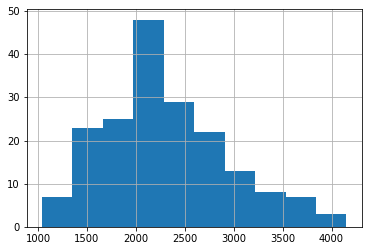

In [235]:
PH_output['waitingTimeSimulation'].dt.seconds.hist()

<AxesSubplot:>

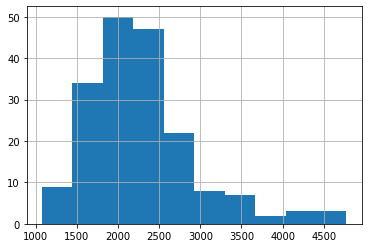

In [236]:
PH_output['waitingTimeReal'].dt.seconds.hist()

In [237]:

PHD_output['arrivalTimeSimulation'] = pd.to_datetime(PHD_output['departureTimeSimulation']) +\
                                        pd.to_timedelta(PHD_output['tripTime'],'seconds')
PHD_output['waitingTimeSimulation'] = PHD_output['arrivalTimeSimulation'] - pd.to_datetime(PHD_output['orderTime'])
PHD_output['waitingTimeReal'] = pd.to_datetime(PHD_output['arrivalTime']) - pd.to_datetime(PHD_output['orderTime'])

In [238]:
PHD_output['waitingTimeSimulation'].mean()

Timedelta('0 days 00:37:03.714607')

In [239]:
PHD_output['waitingTimeReal'].mean()

Timedelta('0 days 00:37:11.712765')

In [240]:
pd.concat([PHD_output,PH_output]).to_csv('Output/order57_629_5min_TW.csv',index=False)

In [241]:
output = pd.concat([PHD_output,PH_output])

In [242]:
output['waitingTimeSimulation'].mean()

Timedelta('0 days 00:38:01.878662')

In [243]:
(output['waitingTimeSimulation'].dt.seconds>3000).sum()

42

In [244]:
output.loc[output['waitingTimeSimulation'].dt.seconds>3000]

,orderTime,arrivalTime,foodPreparationTime,waitingTime,departureTime,tripDurationReal,DeliveryLatLon,storeCode,StoreLatLon,tripDurationFromGoogle,shared,hour,min,timeWindow,timeParameter,tripTime,rider,delayed,departureTimeSimulation,arrivalTimeSimulation,waitingTimeSimulation,waitingTimeReal
134,2020-11-03 17:45:00,2020-11-03 18:33:28,00:35:31,0 days 00:48:28.000000000,2020-11-03 18:20:31,777,"22.4617273,114.0068711",PHD629,"22.456107199999998,113.99848390000001",501,1,18,25,501.000000,1.920749,962.295076,30045306,0,2020-11-03 18:25:00,2020-11-03 18:41:02.295076024,00:56:02.295076,00:48:28
202,2020-11-04 15:47:00,2020-11-04 16:25:30,00:23:05,0 days 00:38:30.000000000,2020-11-04 16:10:05,925,"22.469012,114.002131",PHD629,"22.456107199999998,113.99848390000001",521,1,16,15,840.817978,1.920749,1490.978071,30071365,0,2020-11-04 16:15:00,2020-11-04 16:39:50.978070643,00:52:50.978070,00:38:30
237,2020-11-04 18:29:00,2020-11-04 19:26:44,00:33:27,0 days 00:57:44.000000000,2020-11-04 19:02:27,1457,"22.4646825,113.998206",PHD629,"22.456107199999998,113.99848390000001",488,0,19,5,516.985915,1.920749,1457.000000,30045306,0,2020-11-04 19:02:27,2020-11-04 19:26:44.000000000,00:57:44,00:57:44
238,2020-11-04 18:19:00,2020-11-04 19:19:09,00:48:55,0 days 01:00:09.000000000,2020-11-04 19:07:55,674,"22.4603584,114.0041407",PHD629,"22.456107199999998,113.99848390000001",466,0,19,10,466.000000,1.920749,895.068873,11151158,0,2020-11-04 19:10:00,2020-11-04 19:24:55.068873108,01:05:55.068873,01:00:09
239,2020-11-04 18:15:00,2020-11-04 19:35:05,00:52:56,0 days 01:20:05.000000000,2020-11-04 19:07:56,1629,"22.4672846,113.9975793",PHD629,"22.456107199999998,113.99848390000001",408,0,19,10,44890.829306,1.920749,1281.068873,11151158,0,2020-11-04 19:10:00,2020-11-04 19:31:21.068873108,01:16:21.068873,01:20:05
342,2020-11-05 18:43:00,2020-11-05 19:57:22,00:38:07,0 days 01:14:22.000000000,2020-11-05 19:21:07,2175,"22.4533021,114.0058157",PHD629,"22.456107199999998,113.99848390000001",611,1,19,25,611.000000,1.920749,1173.577428,10797055,0,2020-11-05 19:25:00,2020-11-05 19:44:33.577428045,01:01:33.577428,01:14:22
343,2020-11-05 18:40:00,2020-11-05 19:44:18,00:41:07,0 days 01:04:18.000000000,2020-11-05 19:21:07,1391,"22.449311,114.000853",PHD629,"22.456107199999998,113.99848390000001",436,1,19,25,436.000000,1.920749,837.446413,11151158,0,2020-11-05 19:25:00,2020-11-05 19:38:57.446413466,00:58:57.446413,01:04:18
354,2020-11-05 18:54:00,2020-11-05 20:04:14,00:58:18,0 days 01:10:14.000000000,2020-11-05 19:52:18,716,"22.4670233,113.9999716",PHD629,"22.456107199999998,113.99848390000001",476,0,19,55,44723.186341,1.920749,1019.571869,11151127,0,2020-11-05 19:55:00,2020-11-05 20:11:59.571869291,01:17:59.571869,01:10:14
356,2020-11-05 18:53:00,2020-11-05 20:17:11,00:59:19,0 days 01:24:11.000000000,2020-11-05 19:52:19,1492,"22.4702727,113.9993384",PHD629,"22.456107199999998,113.99848390000001",528,1,19,55,44691.427891,1.920749,1486.571869,11151127,0,2020-11-05 19:55:00,2020-11-05 20:19:46.571869291,01:26:46.571869,01:24:11
369,2020-11-05 19:37:00,2020-11-05 20:31:31,00:42:59,0 days 00:54:31.000000000,2020-11-05 20:19:59,692,"22.4702727,113.9993384",PHD629,"22.456107199999998,113.99848390000001",528,0,20,20,528.000000,1.920749,692.000000,30045306,0,2020-11-05 20:19:59,2020-11-05 20:31:31.000000000,00:54:31,00:54:31


In [245]:
output = output.sort_values(by=['departureTimeSimulation','rider'])
output['last取餐出發時間'] = output['departureTimeSimulation'].shift(1)
output['lastRider'] = output['rider'].shift(1)
output['pre取餐出發時間'] = output['departureTimeSimulation'].shift(-1)
output['preRider'] = output['rider'].shift(-1)
shared = output.loc[((output['last取餐出發時間']==output['departureTimeSimulation'])&(output['lastRider']==output['rider']))|
                   ((output['pre取餐出發時間']==output['departureTimeSimulation'])&(output['preRider']==output['rider']))]
single = output.loc[((output['last取餐出發時間']!=output['departureTimeSimulation'])|(output['lastRider']!=output['rider']))|
                   ((output['pre取餐出發時間']!=output['departureTimeSimulation'])|(output['preRider']!=output['rider']))]

In [246]:
shared.shape

(115, 26)

In [247]:
output.waitingTimeSimulation.mean()

Timedelta('0 days 00:38:01.878662')

In [248]:
output.loc[order['rider']=='3rd']

,orderTime,arrivalTime,foodPreparationTime,waitingTime,departureTime,tripDurationReal,DeliveryLatLon,storeCode,StoreLatLon,tripDurationFromGoogle,shared,hour,min,timeWindow,timeParameter,tripTime,rider,delayed,departureTimeSimulation,arrivalTimeSimulation,waitingTimeSimulation,waitingTimeReal,last取餐出發時間,lastRider,pre取餐出發時間,preRider


In [249]:
output.shape

(279, 26)